# Overfitting

*In which we practice one thing so much that we get worse at everything else.*


### Define Constants


In [36]:
CACHE_FILE = '../cache/crabs.feather'
NEXT_NOTEBOOK = '../1-models/models.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]


### Importing Libraries


In [37]:
from notebooks.time_for_crab.mlutils import data_downcasting, display_df

import keras
import numpy as np
import pandas as pd

#from sklearn.svm import SVC
#from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


### Load Data from Cache

In the [previous section](../0-eda/eda.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [38]:
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs)


DataFrame shape: (3893, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3893 no

## Overfitting Crab Age

![Large mud crab measure](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg/1920px-CSIRO_ScienceImage_10696_Mud_crabs_are_caught_measured_tagged_and_released_as_part_of_the_research_into_the_effectiveness_of_green_zones_in_Moreton_Bay.jpg)


### Overfitting Goals and Methods 

The goal here is to show how complex of a model it will take to overfit the data.

We will use the following methods to overfit the data:

1. **Linear Regression**: Gradually increase the complexity of a linear regression model.
2. **Model Stacking**: Stack models to overfit the model.

> There are two steps in your single-variable linear regression model:  
>    1. Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
>    2. Apply a linear transformation ($y = mx + b$) to produce 1 output using a linear layer (tf.keras.layers.Dense).
>
> https://www.tensorflow.org/tutorials/keras/regression#linear_regression_with_one_variable 

Instead of 'Horsepower', we'll use 'Shell Weight' as the regression variable.


### Normalize Shell Weight

This accounts for the effect of outliers on the variance of the data.
 

In [39]:
shell_weight = np.array(crabs['Shell Weight'])
shell_weight_normalizer = keras.layers.Normalization(axis=None)
shell_weight_normalizer.adapt(shell_weight)


### Build the Shell Weight Model

This is a simple linear regression model that predicts the age of a crab based on its shell weight. It remains untrained.


In [40]:
shell_weight_model = keras.Sequential([
    keras.layers.Input(shape=(1,)),
    shell_weight_normalizer,
    keras.layers.Dense(units=1)
])

shell_weight_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

### Predict Before Training (For Science)

We don't expect good results here. This is just to get a baseline.


In [41]:
shell_weight_model.predict(shell_weight[:10])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[-0.00920763],
       [-0.9496255 ],
       [-0.7312984 ],
       [-0.28118688],
       [-0.92395043],
       [ 0.07861901],
       [-0.35838935],
       [ 0.06586998],
       [ 0.6261189 ],
       [-0.854539  ]], dtype=float32)

### Compile the Model

We will use the mean squared error as the loss function and the Adam optimizer.


In [42]:
shell_weight_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)


### Train the Model

Let's train for 100 epochs.


In [43]:
%%time
history = shell_weight_model.fit(
    x=crabs['Shell Weight'],
    y=crabs[PREDICTION_TARGET],
    epochs=100,
    verbose=0,
    validation_split=0.2
)


CPU times: total: 2.06 s
Wall time: 8.05 s


### Plot the Training History


In [44]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()


,loss,val_loss,epoch
95,6.436975,6.234833,95
96,6.392867,6.507339,96
97,6.436064,6.266227,97
98,6.382323,6.257657,98
99,6.391159,6.177843,99


### Plot the Loss History


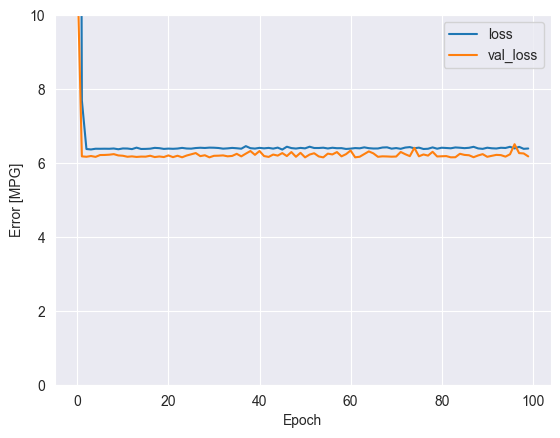

In [45]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


### Don't Save this Data

We don't want our over-trained model to leak into the [next step](../1-models/models.ipynb).


### Onwards to Model Selection

See the [next section](../1-models/models.ipynb) for model selection.
